<a href="https://colab.research.google.com/github/CharlottePrimiceri/VP_Project/blob/main/segmented_video/Segmented_video_Mask_RCNN_and_Pytorch_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmented video generation applying the pre-trained Mask-RCNN and our trained U-Nets**

In [1]:
! pip install torch --quiet

In [2]:
! pip install torchvision --quiet

In [3]:
! pip install scikit-image --quiet

In [4]:
! pip install opencv-python --quiet

In [5]:
! pip install Pillow --quiet

In [ ]:
! pip install timm --quiet

In [7]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import matplotlib as plt
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import torchvision
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
from torch.autograd import Variable

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [8]:
device = 'cpu'

### Define useful functions

In [ ]:
#sort frames in order to create the video from the right sequence of frames

def frame_sort_key(filename):
    return int(filename.split('.')[0][20:26])

def generate_video(img_folder, video_name, out_path):

    images = [img for img in os.listdir(img_folder)]
    images.sort(key=frame_sort_key)
    frame = cv2.imread(os.path.join(img_folder, images[0]))
    height, width, layers = frame.shape

    os.chdir(out_path)

    video = cv2.VideoWriter(video_name, 0, 10, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(img_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [ ]:
"""
### function to rename image files in folders

path_segmented_car = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/predict_segmented_unet"

list_frames = [frame for frame in os.listdir(path_segmented_car) if frame.endswith(".png")]

for i, list_frames in enumerate(list_frames, start=1):
    new_filename = f"{i:04d}.png"

    old_path = os.path.join(path_segmented_car, list_frames)
    new_path = os.path.join(path_segmented_car, new_filename)

    os.rename(old_path, new_path)

    print(f"Renamed '{list_frames}' to '{new_filename}'")
"""

### Convert Video to Image Sequence

capture = cv2.VideoCapture('/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/')

Nframe = 0
while (True):
    success, frame = capture.read()
    if success:
        cv2.imwrite(f'/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/video_car/out_img2/{frameNr:04d}.jpg', frame)
    else:
        break
    Nframe = Nframe+1
capture.release()

## Cityscapes Conversion to COCO Format

In [ ]:
! git clone https://github.com/ISSResearch/Dataset-Converters

In [ ]:
! pip install -r /content/Dataset-Converters/requirements.txt --quiet

In [ ]:
! python /content/Dataset-Converters/convert.py -i /content/drive/MyDrive/VPPROJECT/cityscapes -o /content/drive/MyDrive/VPPROJECT/cityscapes/annotations -I CITYSCAPES -O COCO --copy

### Filtering 3 Classes: Person, Car and Bicycle

In [ ]:
filtered_annotations_file = "filtered_annotations.json"

classes = [1, 2, 3]

with open("/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/annotations/train.json", "r") as f:
    data = json.load(f)

filtered_annotations = {
    "images": data["images"],
    "categories": [category for category in data["categories"] if category["id"] in classes],
    "annotations": [annotation for annotation in data["annotations"] if annotation["category_id"] in classes]
}

with open(filtered_annotations_file, "w") as f:
    json.dump(filtered_annotations, f)

In [ ]:
with open('/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/train.json') as json_data:
    data = json.load(json_data)
    df3_pandas = pd.DataFrame(data['categories'])
df3_pandas
list_of_values = [1, 3, 8]
df3 = df3_pandas[df3_pandas['id'].isin(list_of_values)]
print(df3)
df3_json = df3.to_dict(orient='dict')

## Build video with Detectron2

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13' --quiet

In [10]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode

### Detectron2 configuration

In [11]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:01, 154MB/s]                           


#### Register Dataset Annotations

In [12]:
DatasetCatalog.clear()

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/filtered_annotations.json", "/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/train")
nuts_metadata = MetadataCatalog.get('my_dataset_train').set(thing_colors=[(255,0,0), (0,255,0), (0,0,255)])
dataset_dicts = DatasetCatalog.get('my_dataset_train')

### Visualize Original Image and Prediction

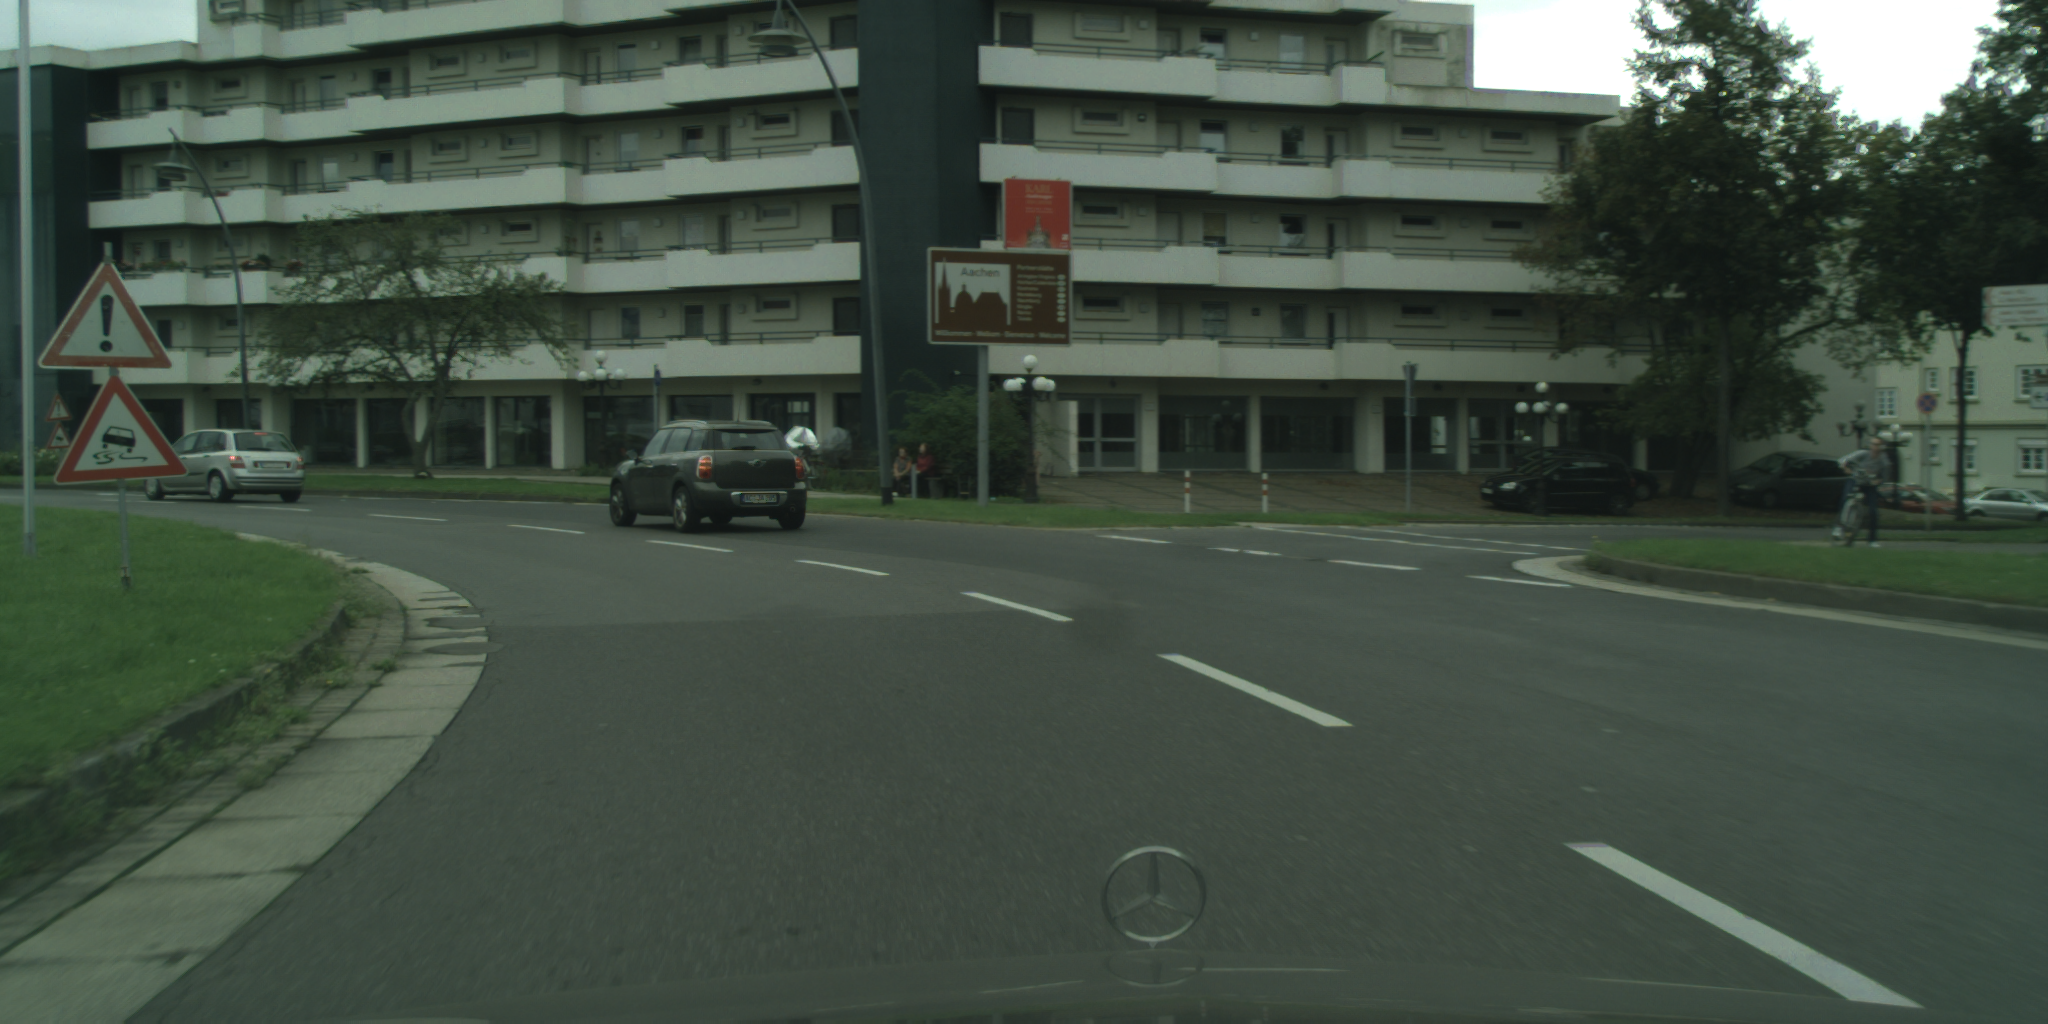

In [14]:
im = cv2.imread("/content/drive/MyDrive/VPPROJECT/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png")
cv2_imshow(im)

In [ ]:
# ResNet 50 as backbone
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Load previous weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [16]:
# prediction values of classes and bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([2, 2, 0, 2, 2, 2, 0, 2, 0, 2])
Boxes(tensor([[1477.3279,  448.2769, 1644.8719,  516.0687],
        [1960.8186,  484.7649, 2047.9060,  522.6849],
        [1836.2566,  431.2328, 1896.1440,  545.3632],
        [ 156.0142,  428.9740,  307.6778,  503.2772],
        [ 606.8896,  420.1949,  804.5816,  532.1324],
        [1729.8647,  452.7651, 1856.3381,  512.1056],
        [ 891.7210,  444.9366,  913.6721,  499.3926],
        [1869.6317,  483.2805, 1959.5563,  515.6665],
        [ 913.9393,  439.7858,  938.0527,  498.6306],
        [1837.0076,  482.2849, 1962.5577,  529.0285]]))


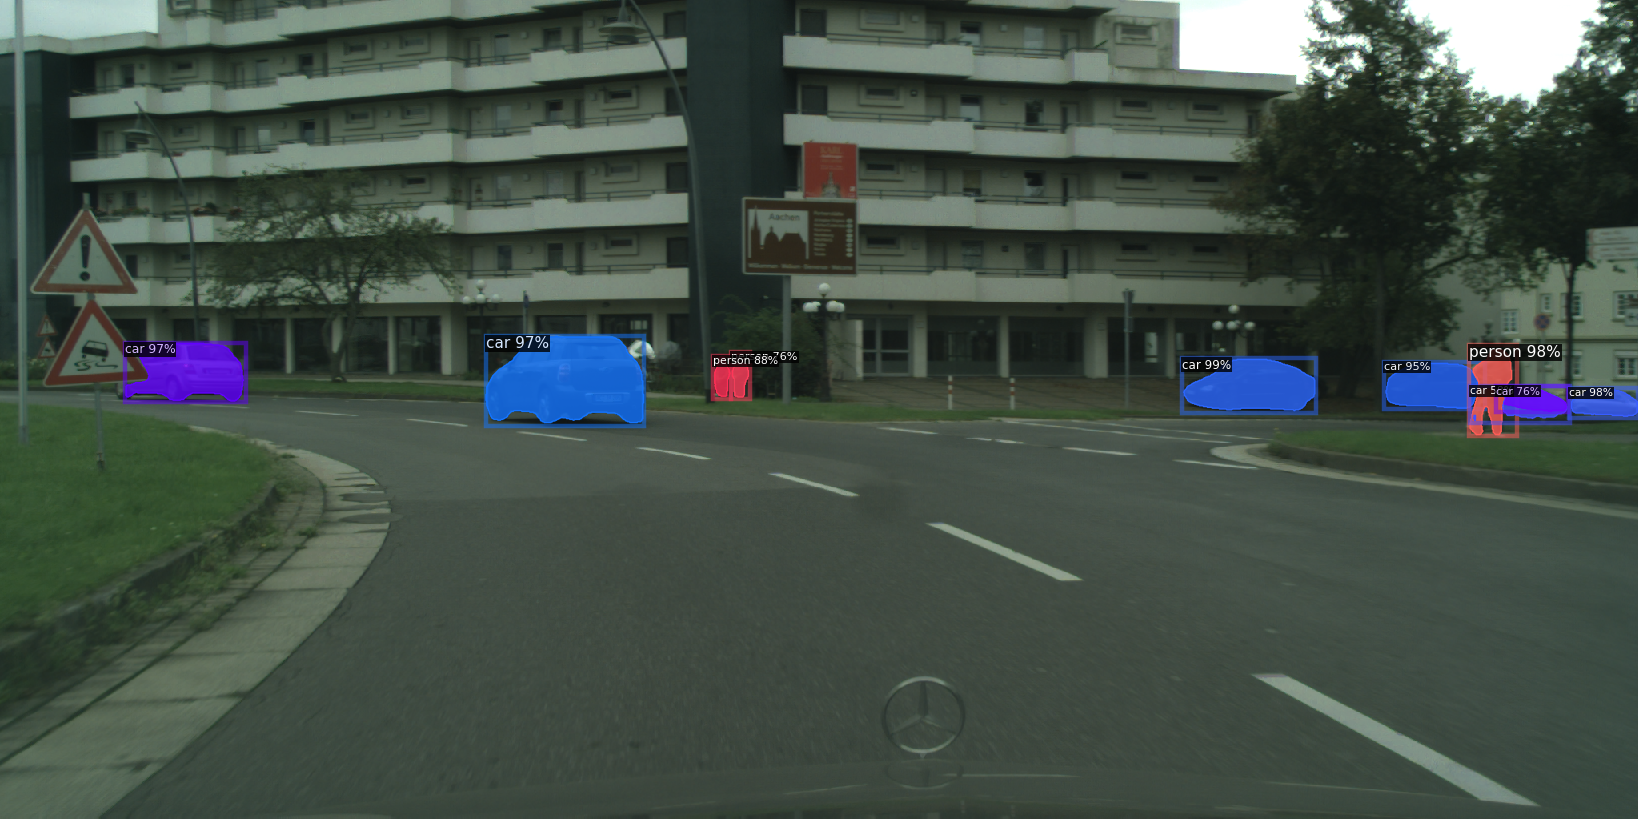

In [18]:
# Set different shades of colors for different classes
v = Visualizer(im[:, :, ::-1], nuts_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

### Generate segmented frames

In [ ]:
images_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02" # original frames
segmented_frames_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/mask_segm_frames/" # segmented frames
built_video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/mask_built_video/" # complete video

for image in os.listdir(images_path):
    image_path = os.path.join(images_path, image)
    im = cv2.imread(image_path)

    # here we segment the image with the pre-trained Mask-RCNN
    pred = predictor(im)
    instances = pred["instances"]
    target_car_id = 0 #for pedestrian id=2
    car_instances = instances[instances.pred_classes == target_car_id]
    v = Visualizer(im[:, :, ::-1], nuts_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
    out = v.draw_instance_predictions(car_instances.to("cpu"))
    path = os.path.join(segmented_frames_path, image)
    cv2.imwrite(path, out.get_image()[:, :, ::-1])

### Build video

In [ ]:
# Build video from folder segmented_video
generate_video(segmented_frames_path, "segmented_video_1.avi", built_video_path)
print("The segmented video has been generated now!")

The segmented video has been generated now!


## Single-channel Pytorch-UNet PREDICT SCRIPT

### Upload Unet model

In [ ]:
############# MODEL BLOCKS ######################################

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model


def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

################## MODEL #################################


class UnetGenerator(nn.Module):

    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1, self.num_filter*2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8, self.num_filter*16, act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block_2(self.num_filter*16, self.num_filter*8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block_2(self.num_filter*8, self.num_filter*4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block_2(self.num_filter*4, self.num_filter*2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_block_2(self.num_filter*2, self.num_filter*1, act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1, down_4], dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2, down_3], dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3, down_2], dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4, down_1], dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

generator = UnetGenerator(3, 4, 64).to(device)

parser = argparse.ArgumentParser()
parser.add_argument("--num_gpu", type=int, default=0, help="number of gpus")
parser.add_argument("-f", required=False)
args = parser.parse_args()

# load pretrained model if it is there
print("loading unet model...")
file_model = '/content/drive/MyDrive/VPPROJECT/50epoch_nodepth/unet.pkl'
if os.path.isfile(file_model):
    generator = torch.load(file_model, map_location=torch.device('cpu'))
    print("    - model restored from file....")
    print("    - filename = %s" % file_model)
else:
    print("unable to load unet.pkl model file")
    exit()

### Generate segmented frames with Unet

In [ ]:
print("\n(predicting all the segmented frames will take a while)...")

# load images from folder
folder_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02"
segmented_images = []
i = 0
for file in os.listdir(folder_path):
      i+=1
      img_path = os.path.join(folder_path, file)
      image = Image.open(img_path).convert('RGB')
      transform_image = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR),
                                    torchvision.transforms.ToTensor()])
      image = transform_image(image)
      image = torch.unsqueeze(image, 0)
      x = Variable(image).to(device)
      y = generator.forward(x)
      pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
      for idx in range(0, y.size()[0]):
          pred_class[idx] = torch.argmax(y[idx], dim=0).to(device).int()
      pred_class = pred_class.unsqueeze(1).float()
      v_utils.save_image(pred_class.float()/y.size()[1], '/content/drive/MyDrive/VPPROJECT/50epoch_nodepth/segmented_frames/gen_image_{}.png'.format(i))

### Build video

In [ ]:
# Build video from folder segmented_video
segmented_video_unet_path = "/content/drive/MyDrive/VPPROJECT/50epoch_nodepth/segmented_frames/"
built_video_unet_path = "/content/drive/MyDrive/VPPROJECT/50epoch_nodepth/video_built/"
generate_video(segmented_video_unet_path, "segmented_video_unet_nodepth.avi", built_video_unet_path)
print("The segmented video has been generated now!")

# Build video with double-channel Pytorch-Unet

### Upload Unet model

In [ ]:
############# MODEL BLOCKS ######################################

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model


def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model


################   UNET 1   #####################################

class unet_without_last_layers_1(nn.Module):

        def __init__(self, in_dim, out_dim, num_filter):
                super(unet_without_last_layers_1, self).__init__()
                self.in_dim = in_dim
                self.out_dim = out_dim
                self.num_filter = num_filter
                act_fn = nn.LeakyReLU(0.2, inplace=True)

                self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
                self.pool_1 = maxpool()
                self.down_2 = conv_block_2(self.num_filter*1, self.num_filter*2, act_fn)
                self.pool_2 = maxpool()
                self.down_3 = conv_block_2(self.num_filter*2, self.num_filter*4, act_fn)
                self.pool_3 = maxpool()
                self.down_4 = conv_block_2(self.num_filter*4, self.num_filter*8, act_fn)
                self.pool_4 = maxpool()

                self.bridge = conv_block_2(self.num_filter*8, self.num_filter*16, act_fn)

                self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
                self.up_1 = conv_block_2(self.num_filter*16, self.num_filter*8, act_fn)
                self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
                self.up_2 = conv_block_2(self.num_filter*8, self.num_filter*4, act_fn)
                self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
                self.up_3 = conv_block_2(self.num_filter*4, self.num_filter*2, act_fn)
                self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
                self.up_4 = conv_block_2(self.num_filter*2, self.num_filter*1, act_fn)

        def forward(self, input):

                down_1 = self.down_1(input)
                pool_1 = self.pool_1(down_1)
                down_2 = self.down_2(pool_1)
                pool_2 = self.pool_2(down_2)
                down_3 = self.down_3(pool_2)
                pool_3 = self.pool_3(down_3)
                down_4 = self.down_4(pool_3)
                pool_4 = self.pool_4(down_4)

                bridge = self.bridge(pool_4)

                trans_1 = self.trans_1(bridge)
                concat_1 = torch.cat([trans_1, down_4], dim=1)
                up_1 = self.up_1(concat_1)
                trans_2 = self.trans_2(up_1)
                concat_2 = torch.cat([trans_2, down_3], dim=1)
                up_2 = self.up_2(concat_2)
                trans_3 = self.trans_3(up_2)
                concat_3 = torch.cat([trans_3, down_2], dim=1)
                up_3 = self.up_3(concat_3)
                trans_4 = self.trans_4(up_3)
                concat_4 = torch.cat([trans_4, down_1], dim=1)
                up_4 = self.up_4(concat_4)

                return up_4

################   UNET 2   #####################################

class unet_without_last_layers_2(nn.Module):

        def __init__(self, in_dim, out_dim, num_filter):
                super(unet_without_last_layers_2, self).__init__()
                self.in_dim = in_dim
                self.out_dim = out_dim
                self.num_filter = num_filter
                act_fn = nn.LeakyReLU(0.2, inplace=True)

                self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
                self.pool_1 = maxpool()
                self.down_2 = conv_block_2(self.num_filter*1, self.num_filter*2, act_fn)
                self.pool_2 = maxpool()
                self.down_3 = conv_block_2(self.num_filter*2, self.num_filter*4, act_fn)
                self.pool_3 = maxpool()
                self.down_4 = conv_block_2(self.num_filter*4, self.num_filter*8, act_fn)
                self.pool_4 = maxpool()

                self.bridge = conv_block_2(self.num_filter*8, self.num_filter*16, act_fn)

                self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
                self.up_1 = conv_block_2(self.num_filter*16, self.num_filter*8, act_fn)
                self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
                self.up_2 = conv_block_2(self.num_filter*8, self.num_filter*4, act_fn)
                self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
                self.up_3 = conv_block_2(self.num_filter*4, self.num_filter*2, act_fn)
                self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
                self.up_4 = conv_block_2(self.num_filter*2, self.num_filter*1, act_fn)

        def forward(self, input):

                down_1 = self.down_1(input)
                pool_1 = self.pool_1(down_1)
                down_2 = self.down_2(pool_1)
                pool_2 = self.pool_2(down_2)
                down_3 = self.down_3(pool_2)
                pool_3 = self.pool_3(down_3)
                down_4 = self.down_4(pool_3)
                pool_4 = self.pool_4(down_4)

                bridge = self.bridge(pool_4)

                trans_1 = self.trans_1(bridge)
                concat_1 = torch.cat([trans_1, down_4], dim=1)
                up_1 = self.up_1(concat_1)
                trans_2 = self.trans_2(up_1)
                concat_2 = torch.cat([trans_2, down_3], dim=1)
                up_2 = self.up_2(concat_2)
                trans_3 = self.trans_3(up_2)
                concat_3 = torch.cat([trans_3, down_2], dim=1)
                up_3 = self.up_3(concat_3)
                trans_4 = self.trans_4(up_3)
                concat_4 = torch.cat([trans_4, down_1], dim=1)
                up_4 = self.up_4(concat_4)

                return up_4

#################### MODEL #######################################

class UnetGenerator(nn.Module):

    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        self.unet_first_part_1 = unet_without_last_layers_1(self.in_dim, self.out_dim, self.num_filter)
        self.unet_first_part_2 = unet_without_last_layers_2(self.in_dim, self.out_dim, self.num_filter)
        self.layer_out = nn.Sequential(
            nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1),
            nn.Tanh(),)

    def forward(self, input_image, input_depth):

        up_4_image = self.unet_first_part_1(input_image)
        up_4_depth = self.unet_first_part_2(input_depth)
        up_4_merged = torch.cat((up_4_image, up_4_depth), 1)
        out = self.layer_out(up_4_image)

        return out

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

generator = UnetGenerator(3, 4, 64).to(device)

parser = argparse.ArgumentParser()
parser.add_argument("--num_gpu", type=int, default=0, help="number of gpus")
parser.add_argument("-f", required=False)
args = parser.parse_args()

# load pretrained model if it is there
print("loading unet model...")
file_model = '/content/drive/MyDrive/VPPROJECT/50epochs_depth/unet.pkl'
if os.path.isfile(file_model):
    generator = torch.load(file_model, map_location=torch.device('cpu'))
    print("    - model restored from file....")
    print("    - filename = %s" % file_model)
else:
    print("unable to load unet.pkl model file")
    exit()

### Depth map computation with MiDas

In [ ]:
# Configuration of MiDas for the depth map computation

model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform   # version of MiDas: "DPT_Hybrid"

In [ ]:
def compute_depth_map_midas(img_path):
    img = cv2.imread(img_path)
    img = transform(img).to(device)
    depth_map = midas(img)
    depth_map = torch.nn.functional.interpolate(
             depth_map.unsqueeze(1),
             size=[384, 768],
             mode="bicubic",
             align_corners=False,
             ).squeeze()
    depth = depth_map.cpu().detach().numpy()
    normalized_depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
    depth_rgb = cv2.applyColorMap((normalized_depth * 255).astype(np.uint8), cv2.COLORMAP_JET)
    return depth_rgb, torch.from_numpy(depth_rgb)

# test_model:
# depth_img = compute_depth_map_midas("/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02_short/0010.png")
# cv2_imshow(depth_img)

### Generate segmented frames with Unet

In [ ]:
print("\n(predicting all the segmented frames will take a while)...")

# load images from folder
folder_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02"
segmented_images = []
i = 0
for file in os.listdir(folder_path):
      i+=1
      img_path = os.path.join(folder_path, file)
      depth_map = compute_depth_map_midas(img_path)[1]
      depth_map = depth_map.permute(2,0,1)
      image = Image.open(img_path).convert('RGB')
      transform_image = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR),
                                    torchvision.transforms.ToTensor()])
      transform_depth = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR)])
      image = transform_image(image).unsqueeze(dim=0)
      depth_map = transform_depth(depth_map).unsqueeze(dim=0)
      image = Variable(image).float().to(device)
      depth_map = Variable(depth_map).float().to(device)
      y = generator.forward(image, depth_map)
      pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
      for idx in range(0, y.size()[0]):
          pred_class[idx] = torch.argmax(y[idx], dim=0).to(device).int()
      pred_class = pred_class.unsqueeze(1).float()
      v_utils.save_image(pred_class.float()/y.size()[1], '/content/drive/MyDrive/VPPROJECT/50epochs_depth/segmented_frames/gen_image_{}.png'.format(i))

### Build video

In [ ]:
# Build video from folder segmented_video
segmented_video_unet_path = "/content/drive/MyDrive/VPPROJECT/50epochs_depth/segmented_frames/"
built_video_unet_path = "/content/drive/MyDrive/VPPROJECT/50epochs_depth/video_built/"
generate_video(segmented_video_unet_path, "segmented_video_unet_nodepth.avi", built_video_unet_path)
print("The segmented video has been generated now!")

The segmented video has been generated now!


## References

- Mask-RCNN:
https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
- Video taken from: https://www.cityscapes-dataset.com/

In [ ]:
@misc{wu2019detectron2,
author = {Yuxin Wu and Alexander Kirillov and Francisco Massa and
              Wan-Yen Lo and Ross Girshick},
title = {Detectron2},
howpublished = {\url{https://github.com/facebookresearch/detectron2}},
year = {2019}
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021}